# Bayesian Networks with PyMC3, NetworkX, and PMML
#### Example taken from Manufacturing Uncertainty with Bayesian Networks *(S. Nannapaneni et al. 2016)*

In [1]:
## For debbugging
%load_ext autoreload

In [2]:
## for debugging:
%aimport pmml.bn
%aimport pymcnet.net
%aimport pymcnet.expr_parse
%autoreload 1
from pymcnet.net import *
from pmml.bn import *  # for reading in PMML

In [3]:
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
%matplotlib inline

![weld](./weld.PNG)

The Volume of a weld is given as 
$$V = L\left(\frac{3}{4}lh+gt+\frac{l-g}{2}(t-e)\right)$$
Where V and L represent the volume of the weld and the length of the weld respectively. Assuming the filler and metal are the same material, we model the theoretical enery required for the weld process to be given as 

$$E_{AP}^{TR} = \rho(C_p(T_f-T_i)+H)V $$

where $E$, $\rho$, $C_p$, $T_f$, $T_i$, $H$ represent the theoretical minimum energy, density of the material, heat capacity, final and initial temperatures, and latent heat of the material

This can be codified as a Bayes Net. We assume that the dimensioning parameters $l$, $h$, $e$ are random variables, each with unknown distribution parameters $\mu$, $\sigma$ (assuming they are Normally distributed). 

![net](./weldBN.PNG)
In addition, we have observed values for $l$, $h$, $e$, allowing us to update the posterior distribution using MCMC (Or, in the case of PyMC3, the No-U-Turn Sampler a.k.a. NUTS)

### Sampling the prior and posterior
To get an approximation for our current belief in the distribution for minimum energy usage, we will perform sampling without any observations, and then we will add observation attributes to the network

#### First, we need some "observed data"

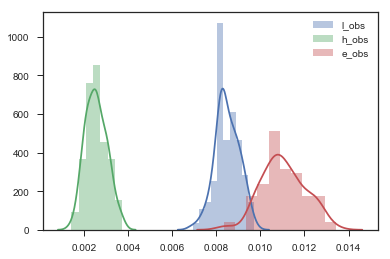

In [4]:
from scipy.stats import norm
import numpy as np
# Synthetic Data-set (observations)
np.random.seed(19806) #random.org, for reproduceability

num_obs = 100
l_obs = norm(8.5*1e-3, 0.5*1e-3).rvs(size=100)
h_obs = norm(2.6*1e-3, 0.5*1e-3).rvs(size=100)
e_obs = norm(11.*1e-3, 1.*1e-3).rvs(size=100)
synth = pd.DataFrame(data=np.array([l_obs, h_obs, e_obs]).T, 
                     columns=['l','h','e'])
for i in [l_obs, h_obs, e_obs]:
    sns.distplot(i)
plt.legend([
    'l_obs',
    'h_obs',
    'e_obs'
])

#### The unobserved (a.k.a. "prior") network: 

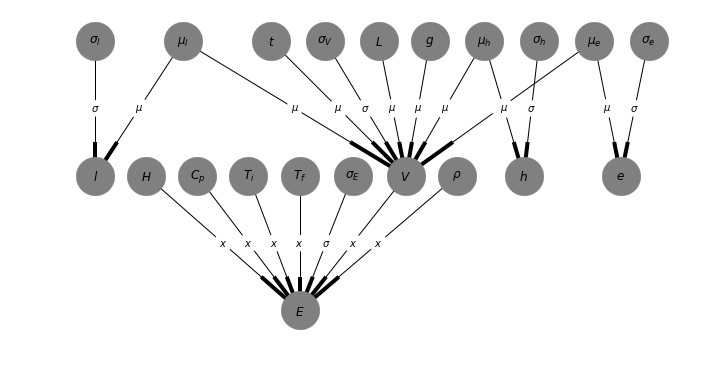

In [34]:
# import theano.tensor as T
D = BayesianNetwork()

D.add_node('mu_l',
           lower=8.3e-3, upper=8.6e-3,
           dist_type='Uniform')
D.add_node('sd_l',
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')
D.add_node('l',
           dist_type='Normal',
           exprs = {'mu':'mu_l',
                    'sd':'sd_l'})
D.add_edge('mu_l','l', var='mu')
D.add_edge('sd_l', 'l', var='sd')

D.add_node('mu_h',
           lower=2.5e-3, upper=2.8e-3,
           dist_type='Uniform')
D.add_node('sd_h',
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')
D.add_node('h',
           dist_type='Normal',
           exprs = {'mu':'mu_h',
                    'sd':'sd_h'})
D.add_edge('mu_h','h', var='mu')
D.add_edge('sd_h', 'h', var='sd')

D.add_node('mu_e',
           lower=10e-3, upper=13e-3,
           dist_type='Uniform')
D.add_node('sd_e',
           lower=0.8e-3, upper=1.3e-3,
           dist_type='Uniform')
D.add_node('e',
           dist_type='Normal',
           exprs = {'mu':'mu_e',
                    'sd':'sd_e'})
D.add_edge('mu_e','e', var='mu')
D.add_edge('sd_e', 'e', var='sd')

D.add_node('L',
           mu=500e-3, sd=10e-3,
           dist_type='Normal')
D.add_node('g',
           mu=2e-3, sd=0.1e-3,
           dist_type='Normal')
D.add_node('t',
           mu=15e-3, sd=0.5e-3,
           dist_type='Normal')

# D.add_node('V',
#            dist_type='Deterministic',
#            exprs = {'var':'L*((0.75)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)*0.5)'})
D.add_node('sd_V',
           dist_type='Uniform',
           lower=1e-3, upper=1e3)
D.add_node('V',
           dist_type='Normal',
           exprs = {'mu':'L*((0.75)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)*0.5)',
                    'sd': 'sd_V'}
#                     'sd': '0.001'}  # close to deterministic
                    )

D.add_edges_from([(i,'V') for i in ['L', 'mu_l','mu_h','g','t','mu_e']],
                 var='mu')
D.add_edge('sd_V', 'V', var='sd')

D.add_node('rho',
           mu=8238., sd=10.,
          dist_type='Normal')
D.add_node('H',
           mu=270e3, sd=3e3,
           dist_type='Normal')
D.add_node('C_p',
           mu=500., sd=5.,
           dist_type='Normal')
D.add_node('T_i',
           mu=303., sd=.3,
           dist_type='Normal'),
D.add_node('T_f',
           mu=1628., sd=10.,
           dist_type='Normal')

# D.add_node('Energy',
#            dist_type = 'Deterministic',
#            exprs={'var':'rho*V*(C_p*(T_f-T_i) + H)'})
D.add_node('sd_E',
           dist_type = 'Uniform',
           lower=1e-3, upper=1e3)
D.add_node('E',
           dist_type = 'Normal',
           exprs={'mu':'rho*V*(C_p*(T_f-T_i) + H)',
                  'sd': 'sd_E'}
#                   'sd': '0.001'}  # close to deterministic
          )

D.add_edges_from([(i, 'E') for i in ['rho', 'C_p',
                                         'T_f', 'T_i',
                                         'H', 'V']], var='var')
D.add_edge('sd_E', 'E', var='sd')


draw_net(D, pretty=True)

#### The observations can be easily added in: 
Note the graph visualization automatically checks for observed nodes

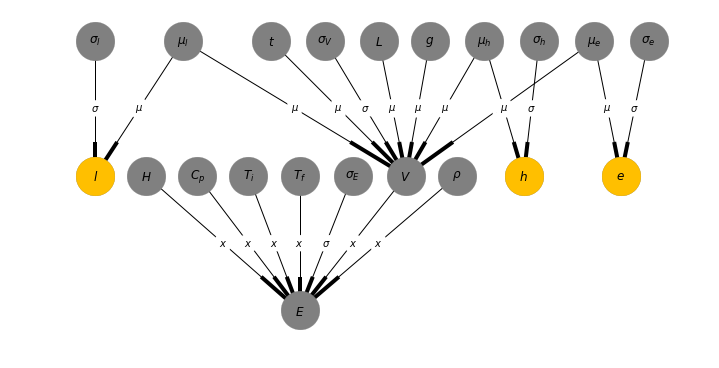

In [35]:
# import theano.tensor as T
# O = BayesianNetwork()

O = D.copy()
O.node['l']['observed'] = synth['l']
O.node['h']['observed'] = synth['h']
O.node['e']['observed'] = synth['e']


draw_net(O, pretty=True)

In [7]:
from networkx.drawing.nx_pydot import write_dot
O.graph['graph'] = {'pad':'0.1', 'ranksep':'.5'}
write_dot(O, 'observed.dot')

!dot -Tpng observed.dot >observed.png
!dot2tex -tmath -ftikz -s observed.dot > observed.tex

![observed.png](observed.png)

#### Instantiation (i.e. Theano Comiling) and Sampling is easy!

In [24]:
n_samp = 200000

with pm.Model() as prior_model:
    instantiate_pm(D, evaluate_exprs=True)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_prior = pm.sample(n_samp, step=step, start=start)
#     trace_prior = pm.sample(n_samp)
    
#     trace_prior = pm.sample(n_samp)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
sd_V
root node; keys:  ['upper', 'lower']
V
child node; keys:  ['mu', 'sd']
rho
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
sd_E
root node; keys:  ['upper', 'lower']
E
child node; keys:  ['mu', 'sd']
         Current function value: 3.320243
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 12


100%|█████████████████████████████████| 200500/200500 [22:33<00:00, 148.18it/s]


In [25]:
with pm.Model() as model:
    instantiate_pm(O, evaluate_exprs=True)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(n_samp, step=step, start=start)
#     trace = pm.sample(n_samp)
    
#     trace = pm.sample(n_samp)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['observed', 'mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['observed', 'mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
sd_V
root node; keys:  ['upper', 'lower']
V
child node; keys:  ['mu', 'sd']
rho
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
sd_E
root node; keys:  ['upper', 'lower']
E
child node; keys:  ['mu', 'sd']
         Current function value: -1760.578769
         Iterations: 58
         Function evaluations: 181
         Gradient evaluations: 169


100%|█████████████████████████████████| 200500/200500 [16:49<00:00, 198.69it/s]


#### Plot the updated belief

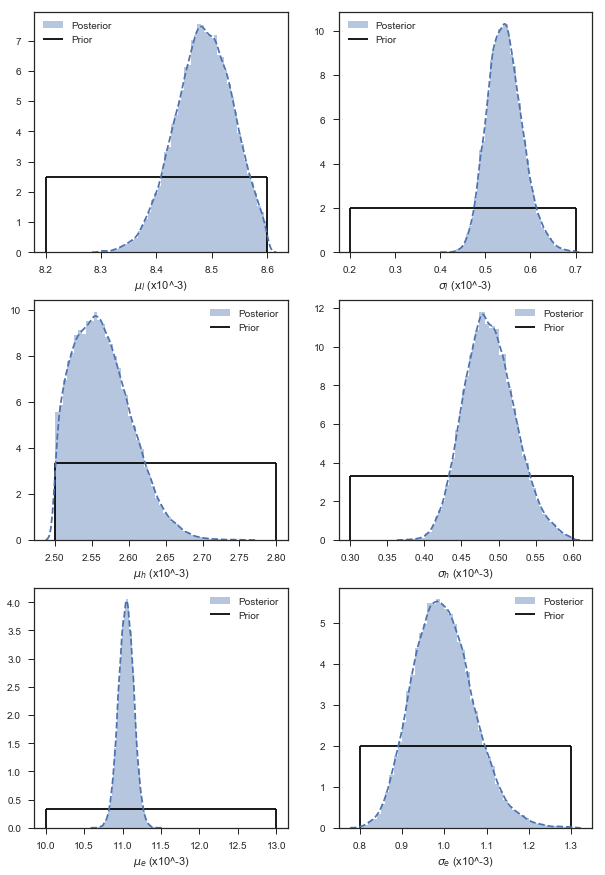

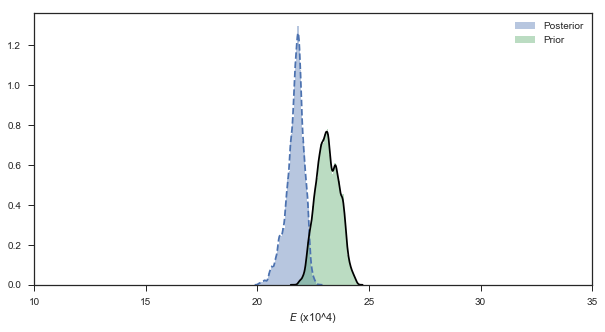

In [26]:
lims = [(8.2e-3, 8.6e-3),
        (0.2e-3, 0.7e-3),
        (2.5e-3, 2.8e-3),
        (0.3e-3, 0.6e-3),
        (10e-3, 13e-3),
        (0.8e-3, 1.3e-3)]
varnames=['mu_l', 'sd_l',
          'mu_h', 'sd_h',
          'mu_e', 'sd_e']
varlabs= [r'$\mu_l$', r'$\sigma_l$',
          r'$\mu_h$', r'$\sigma_h$',
          r'$\mu_e$', r'$\sigma_e$']

def compare_dist(ax, dat, lim, scale=1.):
    sns.distplot(scale*dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
    a,b = scale*lim[0], scale*lim[1]
    y = 1./(b-a)
    ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
    ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
    ax.legend()

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp/2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
    ax.set_xlabel("{} (x10^{})".format(varlabs[n], -3))
plt.show()

f2 = plt.figure(figsize=(10,5))
sns.distplot(trace[n_samp/2:].get_values('E')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp/2:].get_values('E')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel(r'$E$ (x10^{})'.format(4))
plt.xlim(10,35)
plt.show()

#### Compare to the original results: 

![paper](./paper.PNG)

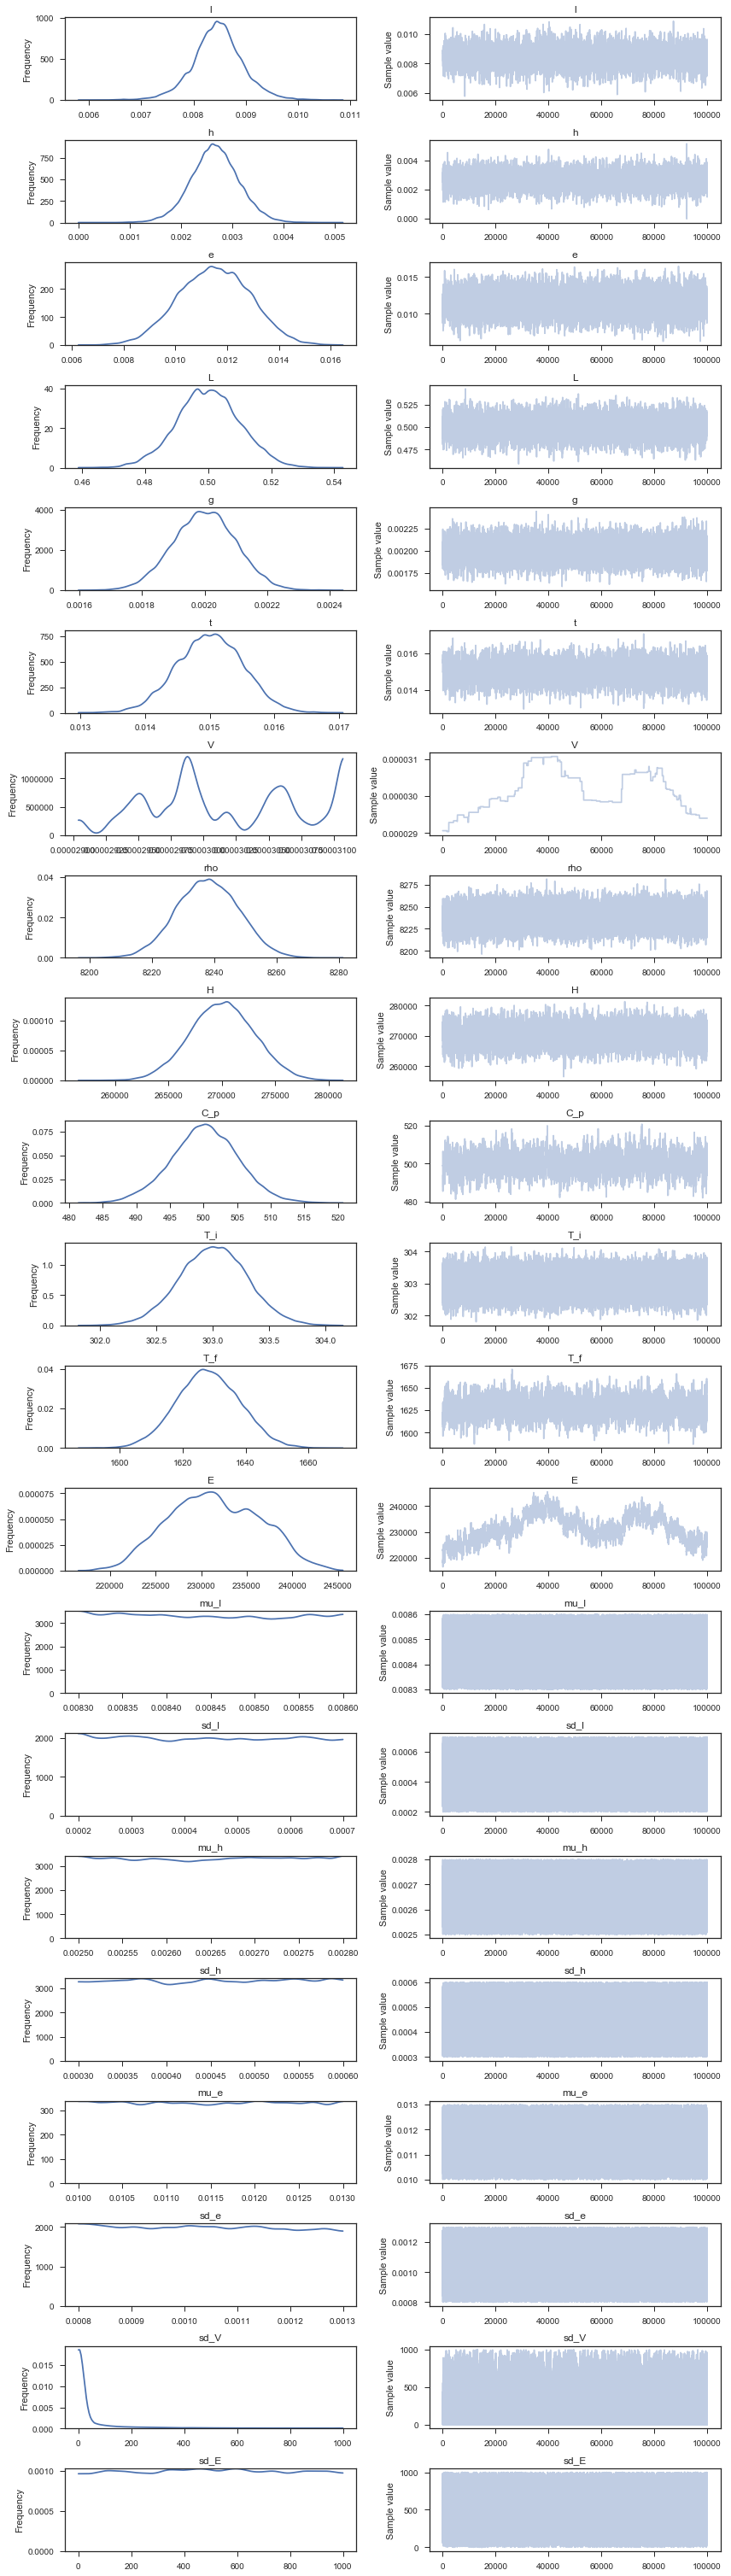

In [27]:
pm.traceplot(trace_prior[n_samp/2:]);

#### Serialization
This model is compatible with the PMML parser in the package. To save it, just call the `toPMML()` network method 

In [12]:
O.toPMML('WeldModelPMML.xml')

mu_l
	Lower 0.0083
	Upper 0.0086
sd_l
	Lower 0.0002
	Upper 0.0007
l
	Mean mu_l
	Variance (sd_l)**2.
mu_h
	Lower 0.0025
	Upper 0.0028
sd_h
	Lower 0.0003
	Upper 0.0006
h
	Mean mu_h
	Variance (sd_h)**2.
mu_e
	Lower 0.01
	Upper 0.013
sd_e
	Lower 0.0008
	Upper 0.0013
e
	Mean mu_e
	Variance (sd_e)**2.
L
	Mean 0.5
	Variance 0.0001
g
	Mean 0.002
	Variance 1e-08
t
	Mean 0.015
	Variance 2.5e-07
sd_V
	Lower 0.001
	Upper 1000.0
V
	Mean L*((0.75)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)*0.5)
	Variance (sd_V)**2.
rho
	Mean 8238.0
	Variance 100.0
H
	Mean 270000.0
	Variance 9000000.0
C_p
	Mean 500.0
	Variance 25.0
T_i
	Mean 303.0
	Variance 0.09
T_f
	Mean 1628.0
	Variance 100.0
sd_E
	Lower 0.001
	Upper 1000.0
E
	Mean rho*V*(C_p*(T_f-T_i) + H)
	Variance (sd_E)**2.
Wrote PMML file to WeldModelPMML.xml


## Reading PMML Files In 

Given some PMML bayes-net file, we can import into our BayesianNetwork graph object, and immediately instantiate into a PyMC3 model. 

Let's try it now: 

In [17]:


bnp = BayesianNetworkParser()

soG = bnp.parse('WeldModelPMML.xml')
soG.node

mu_l
	upper 0.0086
	lower 0.0083
sd_l
	upper 0.0007
	lower 0.0002
l
	sd ['sd_l']
	mu ['mu_l']
mu_h
	upper 0.0028
	lower 0.0025
sd_h
	upper 0.0006
	lower 0.0003
h
	sd ['sd_h']
	mu ['mu_h']
mu_e
	upper 0.013
	lower 0.01
sd_e
	upper 0.0013
	lower 0.0008
e
	sd ['sd_e']
	mu ['mu_e']
L
	sd 0.0001
	mu 0.5
g
	sd 1e-08
	mu 0.002
t
	sd 2.5e-07
	mu 0.015
sd_V
	upper 1000.0
	lower 0.001
V
	sd ['sd_V']
	mu ['L', 'g', 't', 'mu_l', 'g', 't', 'mu_e', 'mu_h', 'mu_l']
rho
	sd 100.0
	mu 8238.0
H
	sd 9000000.0
	mu 270000.0
C_p
	sd 25.0
	mu 500.0
T_i
	sd 0.09
	mu 303.0
T_f
	sd 100.0
	mu 1628.0
sd_E
	upper 1000.0
	lower 0.001
E
	sd ['sd_E']
	mu ['V', 'rho', 'H', 'C_p', 'T_f', 'T_i']


OrderedDict([('mu_l',
              {'dist_type': 'Uniform', 'lower': 0.0083, 'upper': 0.0086}),
             ('sd_l',
              {'dist_type': 'Uniform', 'lower': 0.0002, 'upper': 0.0007}),
             ('l',
              {'dist_type': 'Normal',
               'exprs': {'mu': 'mu_l', 'sd': '(sd_l**2.0)**0.5'},
               'observed': []}),
             ('mu_h',
              {'dist_type': 'Uniform', 'lower': 0.0025, 'upper': 0.0028}),
             ('sd_h',
              {'dist_type': 'Uniform', 'lower': 0.0003, 'upper': 0.0006}),
             ('h',
              {'dist_type': 'Normal',
               'exprs': {'mu': 'mu_h', 'sd': '(sd_h**2.0)**0.5'},
               'observed': []}),
             ('mu_e', {'dist_type': 'Uniform', 'lower': 0.01, 'upper': 0.013}),
             ('sd_e',
              {'dist_type': 'Uniform', 'lower': 0.0008, 'upper': 0.0013}),
             ('e',
              {'dist_type': 'Normal',
               'exprs': {'mu': 'mu_e', 'sd': '(sd_e**2.0)**0.5'},


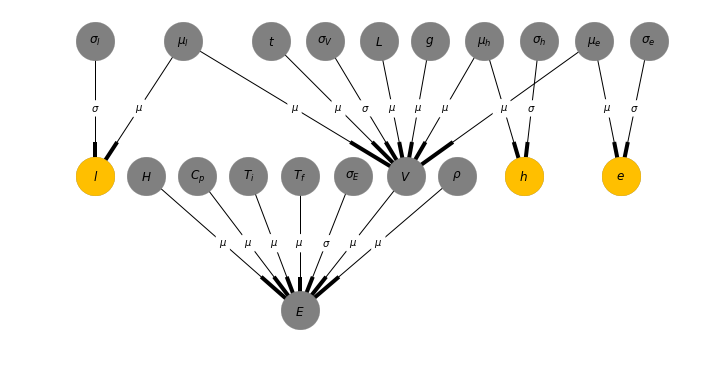

In [18]:
draw_net(soG, pretty=True)

Note that PMML as implemented here does not save the training/observation data, but it will flag which nodes are *supposed* to be observed, as specified in the XML document (note the yellow nodes above). 

We can make another net that will contain the observations, and then set off PyMC3 to do our sampling:

In [19]:
# import theano.tensor as T
# O = BayesianNetwork()

soO = soG.copy()
soO.node['l']['observed'] = synth['l']
soO.node['h']['observed'] = synth['h']
soO.node['e']['observed'] = synth['e']


n_samp = 500

with pm.Model() as prior_model:
    instantiate_pm(soG, evaluate_exprs=True)
    
    step = pm.Metropolis()
    trace_prior = pm.sample(n_samp, step=step)

with pm.Model() as model:
    instantiate_pm(soO, evaluate_exprs=True)
    
    step = pm.Metropolis()
    trace = pm.sample(n_samp, step=step)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['observed', 'mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['observed', 'mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
sd_V
root node; keys:  ['upper', 'lower']
V
child node; keys:  ['mu', 'sd']
rho
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
sd_E
root node; keys:  ['upper', 'lower']
E
child node; keys:  ['mu', 'sd']


100%|█████████████████████████████████████| 1000/1000 [00:05<00:00, 180.08it/s]


mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['observed', 'mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['observed', 'mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
sd_V
root node; keys:  ['upper', 'lower']
V
child node; keys:  ['mu', 'sd']
rho
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
sd_E
root node; keys:  ['upper', 'lower']
E
child node; keys:  ['mu', 'sd']


100%|█████████████████████████████████████| 1000/1000 [00:05<00:00, 180.51it/s]


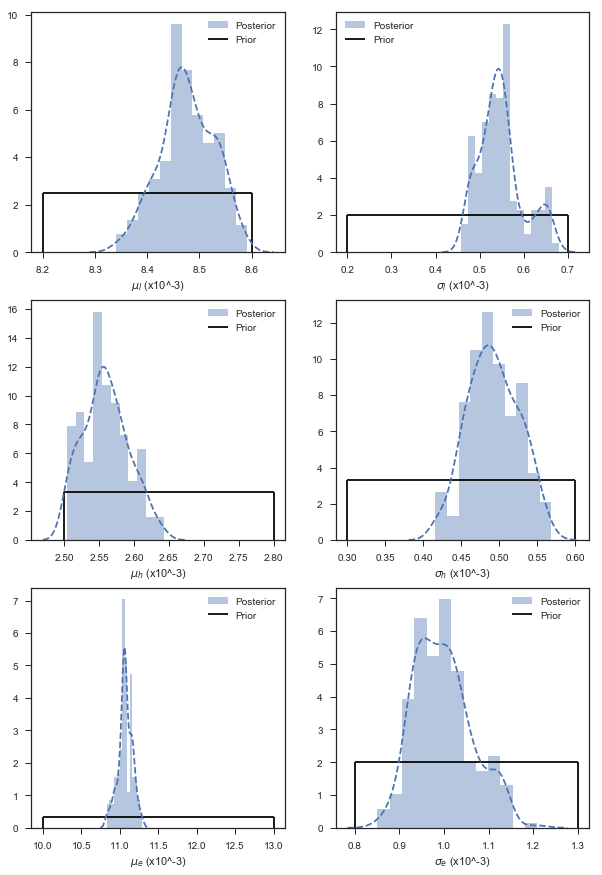

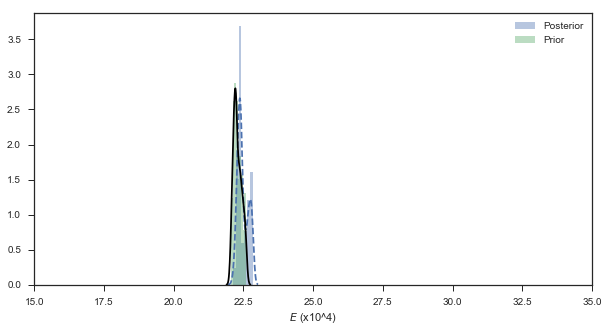

In [20]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp/2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
    ax.set_xlabel("{} (x10^{})".format(varlabs[n], -3))
plt.show()

f2 = plt.figure(figsize=(10,5))
sns.distplot(trace[n_samp/2:].get_values('E')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp/2:].get_values('E')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel(r'$E$ (x10^{})'.format(4))
plt.xlim(15,35)
plt.show()

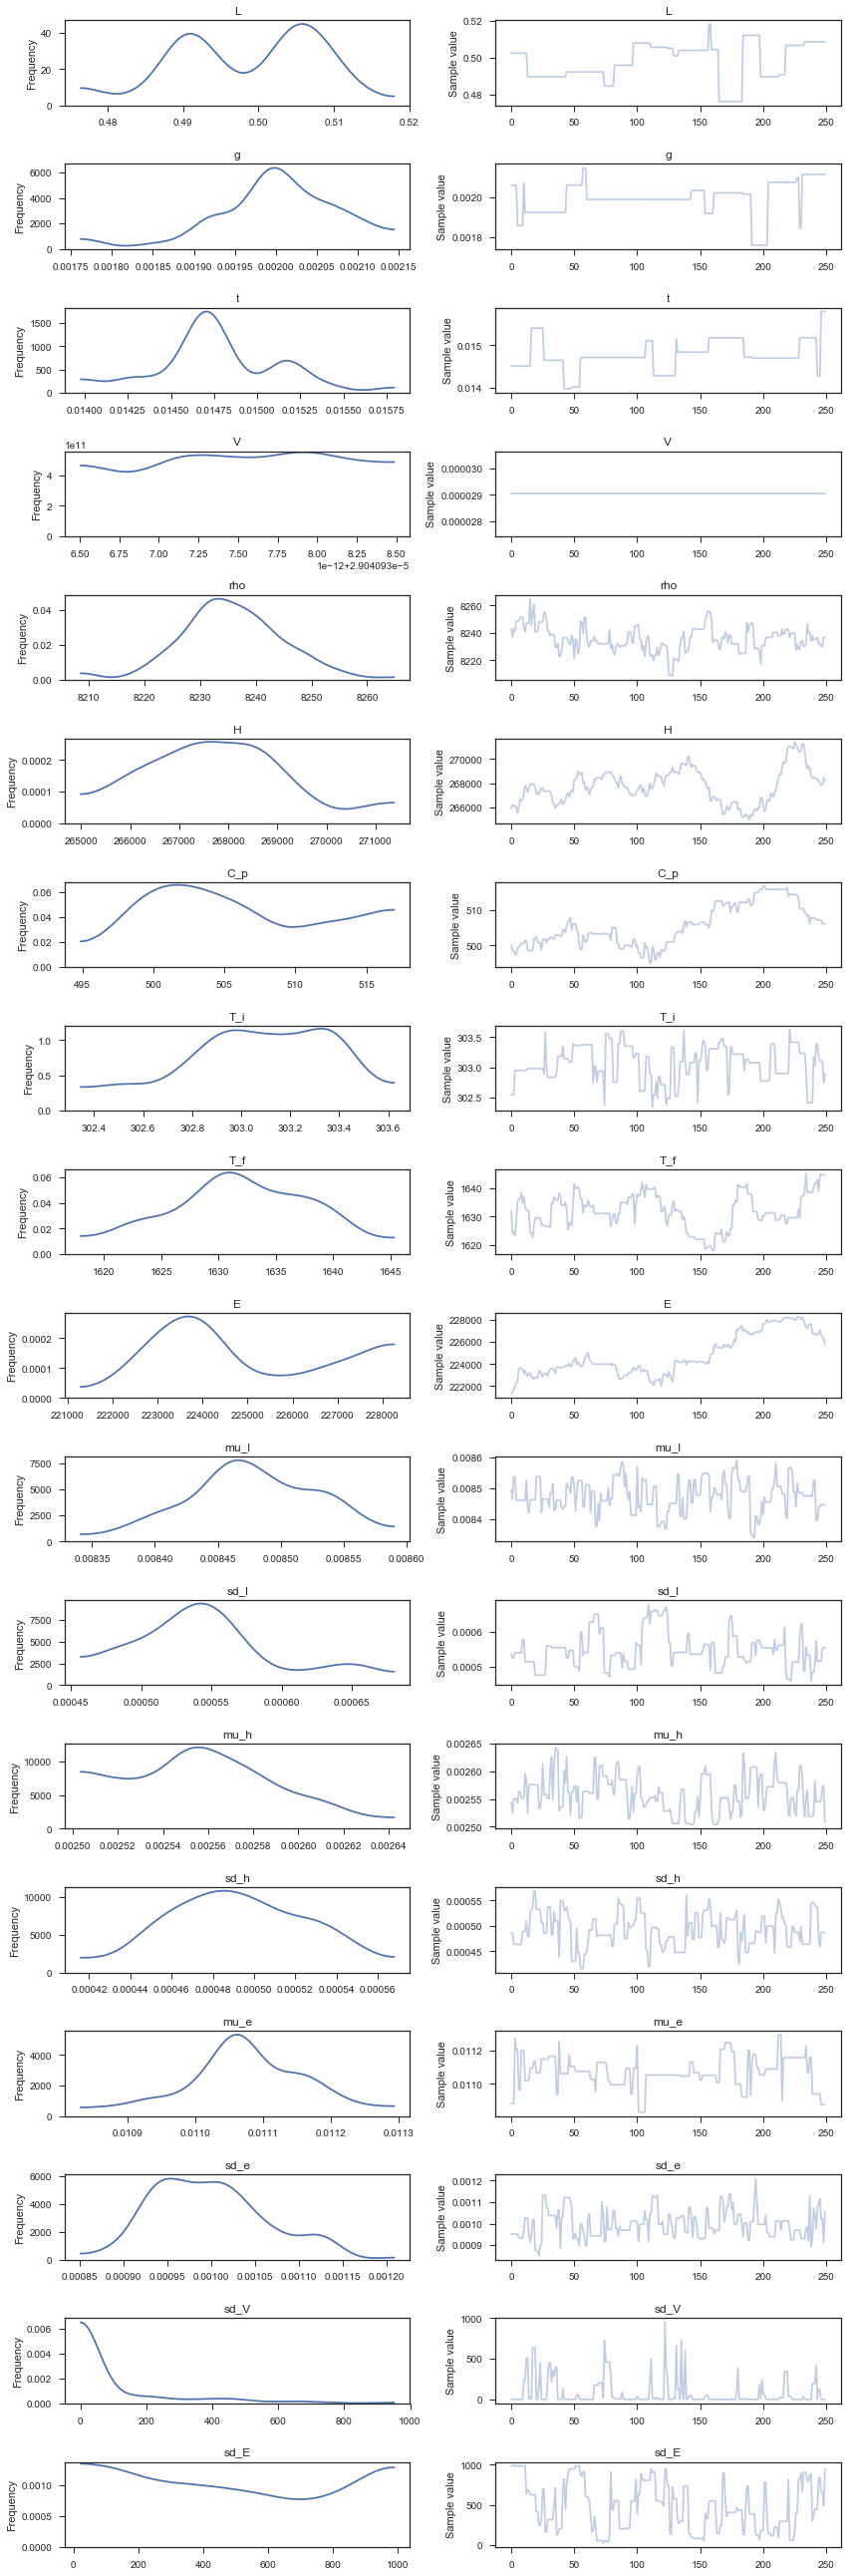

In [21]:
pm.traceplot(trace[n_samp/2:]);